In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import joblib, json, os



In [7]:
# Load your WineQT dataset
df = pd.read_csv("../data/WineQT.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [8]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())
df.describe()

Shape: (1143, 13)

Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Id']

Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [9]:
# Drop the Id column (not useful for modeling)
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# Create binary target: Good wine (quality >= 6), Bad wine (<6)
df["good"] = (df["quality"] >= 6).astype(int)

# Split features (X) and target (y)
X = df.drop(columns=["quality", "good"])
y = df["good"]

X.head(), y.value_counts()


(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  
 0      9.4  
 1      9.8  
 2      9.8  
 3      9.8  
 4

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
common_steps = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]

logreg = Pipeline(common_steps + [("clf", LogisticRegression(max_iter=2000))])
rf     = Pipeline(common_steps + [("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

models = {"Logistic Regression": logreg, "Random Forest": rf}

In [12]:
scorer = {"accuracy": "accuracy", "f1": "f1"}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, pipe in models.items():
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scorer)
    cv_results[name] = {m: scores[f"test_{m}"].mean() for m in scorer}

cv_results

{'Logistic Regression': {'accuracy': np.float64(0.7494085149822854),
  'f1': np.float64(0.7707066545717611)},
 'Random Forest': {'accuracy': np.float64(0.7789827658680119),
  'f1': np.float64(0.798357145219392)}}

In [13]:
best_name = max(cv_results, key=lambda k: cv_results[k]["f1"])
best_model = models[best_name].fit(X_train, y_train)

print(f"Best model: {best_name}")

Best model: Random Forest


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.78       105
           1       0.80      0.85      0.82       124

    accuracy                           0.80       229
   macro avg       0.80      0.80      0.80       229
weighted avg       0.80      0.80      0.80       229

Accuracy: 0.803, F1-score: 0.825


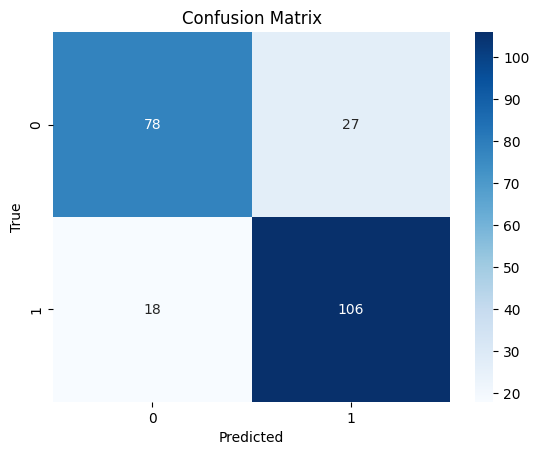

In [14]:
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}, F1-score: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
joblib.dump(best_model, "../model.pkl")

with open("../features.json", "w") as f:
    json.dump(list(X.columns), f)

metrics = {"accuracy": acc, "f1": f1, "best_model": best_name}
with open("../metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Artifacts saved: model.pkl, features.json, metrics.json")

Artifacts saved: model.pkl, features.json, metrics.json


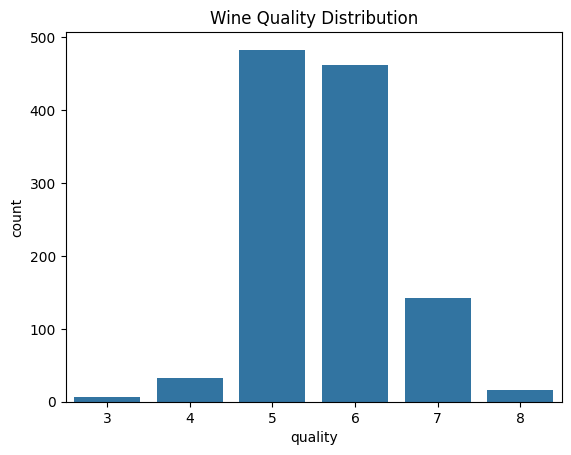

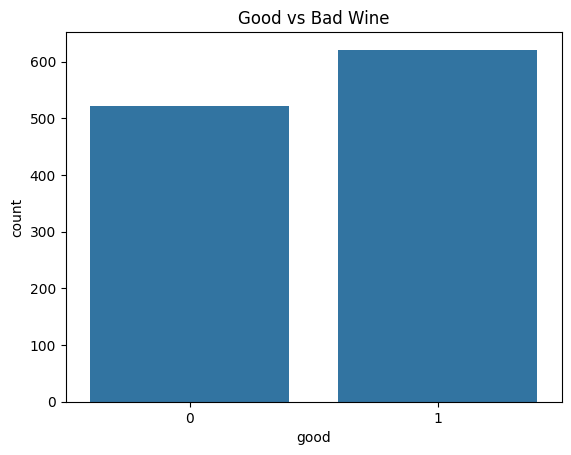

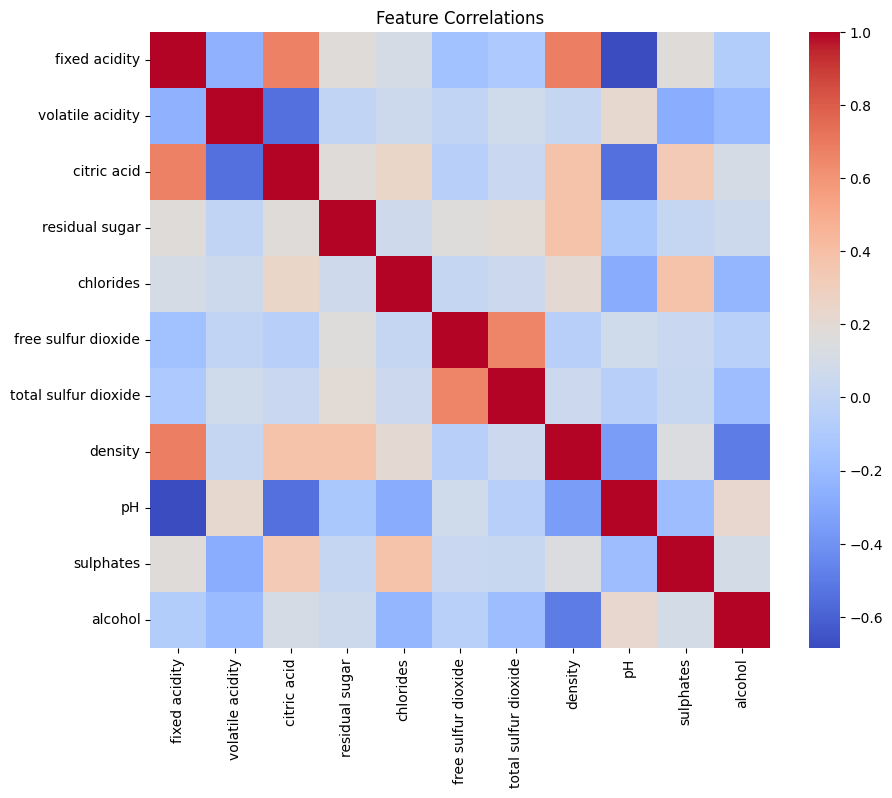

In [16]:
# Target distribution
sns.countplot(x="quality", data=df)
plt.title("Wine Quality Distribution")
plt.show()

# Good vs Bad wine
sns.countplot(x="good", data=df)
plt.title("Good vs Bad Wine")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

# Example interactive plot
fig = px.scatter(df, x="alcohol", y="volatile acidity", color=df["good"].map({0:"Bad",1:"Good"}))
fig.show()